In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.optimize import root
from math import cos, sin

In [2]:
reader = csv.reader(open("recorded_sensor_data/turtlebot_12_07_18-44-00/turtlebot_data.csv", 'r'))

data = []
next(reader)  # skip header
for idx, row in enumerate(reader):
    row = [float(d) for d in row]
    data.append(row)
    
data = np.array(data)
accelerometer_data = data[:,4:7]

In [4]:
print(data[-1][-1] - data[0][-1])
print(data.shape)

24.943764925
(250, 12)


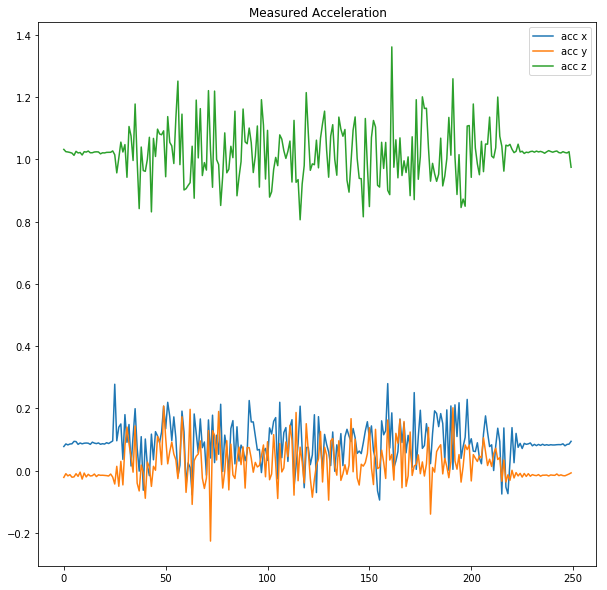

In [3]:
plt.figure(figsize=(10,10))
plt.title("Measured Acceleration")
plt.plot(accelerometer_data[:,0], label='acc x')
plt.plot(accelerometer_data[:,1], label='acc y')
plt.plot(accelerometer_data[:,2], label='acc z')
plt.legend()

plt.show()

## Generic Calibration

compensate for bias, scale, and misalignment

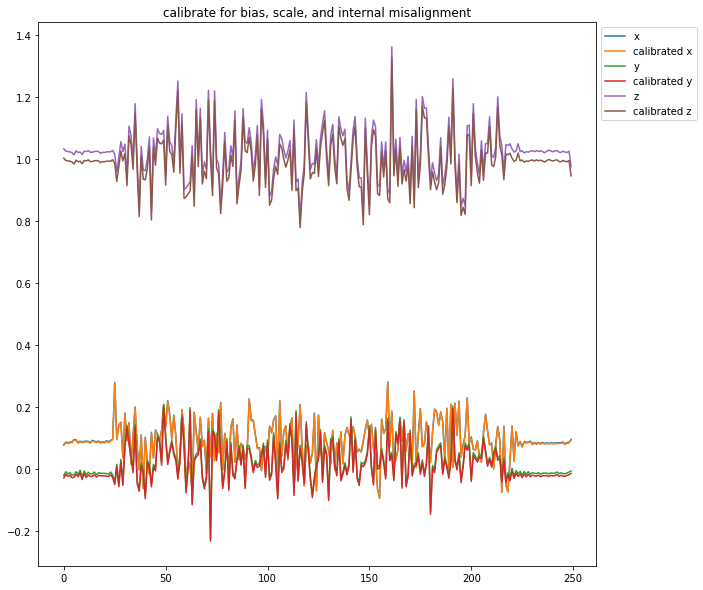

In [63]:
calib_T = np.array([[1, 2.71075764e-03, 4.55981725e-03],[0, 1, 7.38354478e-04],[0,0,1]])
calib_K = np.array([[9.97279234e-01, 0, 0],[0, 9.96661774e-01, 0],[0, 0, 9.89959950e-01]])
calib_b = np.array([[-6.37606144e-03, -8.99928659e-03, -1.99175409e-02]])

calibrated_accelerometer_data = calib_T@calib_K@(accelerometer_data+calib_b).T

plt.figure(figsize=(10,10))
plt.plot(accelerometer_data[:,0], label='x')
plt.plot(calibrated_accelerometer_data[0,:], label='calibrated x')
plt.plot(accelerometer_data[:,1], label='y')
plt.plot(calibrated_accelerometer_data[1,:], label='calibrated y')
plt.plot(accelerometer_data[:,2], label='z')
plt.plot(calibrated_accelerometer_data[2,:], label='calibrated z')
plt.legend(bbox_to_anchor=(1,1))
plt.title("calibrate for bias, scale, and internal misalignment")
plt.show()

calibrated_accelerometer_data = calibrated_accelerometer_data.T

## Body to Accelerometer Frame Calibration

The offset between the coordinate frame of the robot and the accelerometer can be described as a rotation in roll, pitch, and yaw. This rotation can be represented as a matrix multiplication, and we can use the measured acceleration in $x$, $y$, and $z$ to compute these angles. To do this, we assume that when the robot is stationary that the acceleration should be $0$ in $x$ and $y$, and $1$ in $z$. The observed accelerations will differ from these values if there is any misalignment between the IMU and the base frame.

https://math.stackexchange.com/a/476311

In [69]:
t_init = 25 # ~25 is static
stationary_accelerometer_data = calibrated_accelerometer_data[:t_init]
stationary_mean_acc_raw = np.mean(stationary_accelerometer_data, axis=0)
stationary_mean_acc = stationary_mean_acc_raw / np.linalg.norm(stationary_mean_acc_raw)
print(np.linalg.norm(stationary_mean_acc_raw))

a = stationary_mean_acc
b = np.array([0, 0, 1])
v = np.cross(a, b)
s = np.linalg.norm(v)
c = np.dot(a, b)
v_x = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
R = np.eye(3) + v_x + (v_x**2)*(1/(1+c))

print("raw", stationary_mean_acc_raw)
print("normalized", stationary_mean_acc)
print("adjusted", R@stationary_mean_acc)
print(R)

raw [ 0.08578936 -0.02339312  0.99247542]
normalized [ 0.08609492 -0.02347644  0.9960103 ]
adjusted [  4.04225221e-03   1.81356877e-04   1.00428702e+00]
[[ 1.          0.         -0.08238134]
 [ 0.          1.          0.02375256]
 [ 0.08980849 -0.02320032  1.        ]]


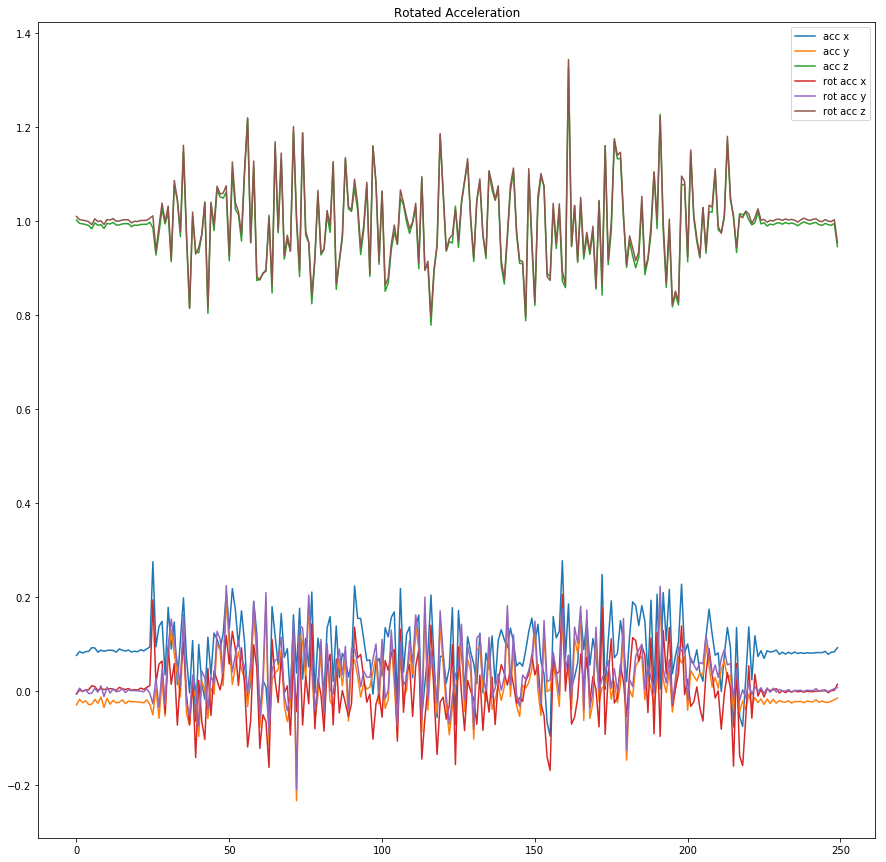

In [70]:
rotated_data = np.ndarray(calibrated_accelerometer_data.shape)
for i, d in enumerate(calibrated_accelerometer_data):
    rotated_data[i] = R@d
    
plt.figure(figsize=(15,15))
plt.title("Rotated Acceleration")
plt.plot(calibrated_accelerometer_data[:,0], label='acc x')
plt.plot(calibrated_accelerometer_data[:,1], label='acc y')
plt.plot(calibrated_accelerometer_data[:,2], label='acc z')
plt.plot(rotated_data[:,0], label='rot acc x')
plt.plot(rotated_data[:,1], label='rot acc y')
plt.plot(rotated_data[:,2], label='rot acc z')

plt.legend()

plt.show()

In [71]:
def DoubleIntegrateAccelerometer(acc_data, T, K, b):
    x = 0
    y = 0
    vx = 0
    vy = 0
    dt_s = 0.01
    xs = []
    ys = []
    vxs = []
    vys = []
    axs = []
    ays = []
    for a_s in acc_data:
        a_o = T@K@(a_s + b).T
        ax = a_o[0][0]
        ay = a_o[1][0]
        az = a_o[2][0]
        
        vx += ax * dt_s
        vy += ay * dt_s
        x += vx * dt_s + 0.5 * ax * dt_s ** 2
        y += vy * dt_s + 0.5 * ay * dt_s ** 2
        axs.append(ax)
        ays.append(ay)
        vxs.append(vx)
        vys.append(vy)
        xs.append(x)
        ys.append(y)
    
    return xs, ys, vxs, vys, axs, ays

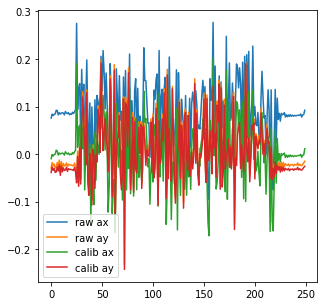

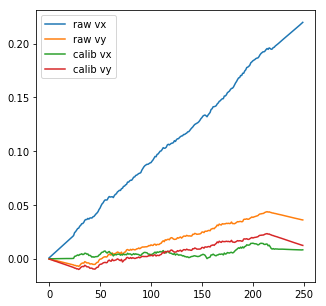

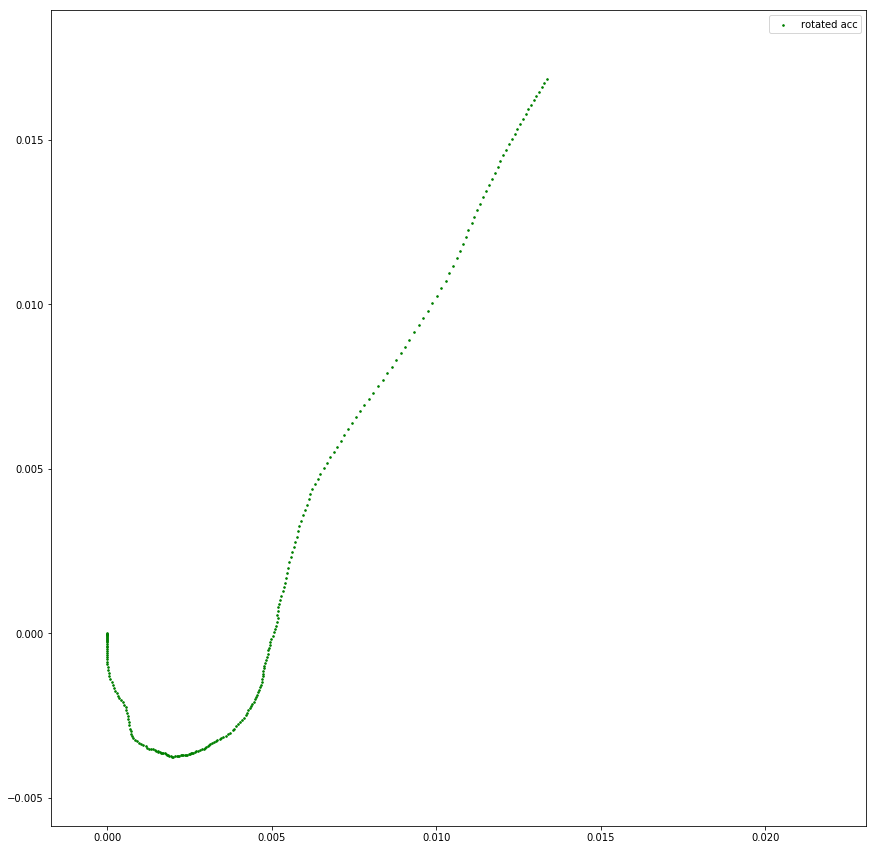

In [72]:
raw = DoubleIntegrateAccelerometer(calibrated_accelerometer_data, np.eye(3), np.eye(3), np.zeros((1,3)))
calib = DoubleIntegrateAccelerometer(calibrated_accelerometer_data, R, np.eye(3), np.array([[-0.003, -0.033, 0]]))
means = np.mean(calibrated_accelerometer_data[:t_init], axis=0)
calib2 = DoubleIntegrateAccelerometer(calibrated_accelerometer_data, np.eye(3), np.eye(3), np.array([[means[0], means[1], 0]]))


plt.figure(figsize=(5,5))
plt.plot(raw[4], label='raw ax')
plt.plot(raw[5], label='raw ay')
plt.plot(calib[4], label='calib ax')
plt.plot(calib[5], label='calib ay')
plt.legend()

plt.figure(figsize=(5,5))
plt.plot(raw[2], label='raw vx')
plt.plot(raw[3], label='raw vy')
plt.plot(calib[2], label='calib vx')
plt.plot(calib[3], label='calib vy')
plt.legend()

plt.figure(figsize=(15,15))
# plt.scatter(raw[0], raw[1], marker='.', s=10, color='m', label='raw data')
plt.scatter(calib[0], calib[1], marker='.', s=10, color='g', label='rotated acc')
plt.legend()
plt.axis('square')
plt.show()